In [1]:
import pandas as pd
import numpy as np
import re
import dill
from sklearn.metrics import roc_curve, confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from lightgbm import LGBMModel,LGBMClassifier
import matplotlib.pyplot as plt

## Import data and view top rows

In [ ]:
dx_df = pd.read_csv('data/DIAGNOSES_ICD.csv',converters={i: str for i in range(100)})[['HADM_ID', 'ICD9_CODE']]
icd_des_df = pd.read_csv('data/D_ICD_DIAGNOSES.csv',converters={i: str for i in range(100)})[['ICD9_CODE','LONG_TITLE']]
note_df = pd.read_csv('data/NOTEEVENTS.csv',converters={i: str for i in range(100)})[['HADM_ID','TEXT']]

In [ ]:
dx_cleaned_df=dx_df[(dx_df['HADM_ID']!='') & (dx_df['ICD9_CODE']!='')]\
                .drop_duplicates().rename(columns={"HADM_ID": "encounter_id","ICD9_CODE": "icd9"})
icd_des_cleaned_df=icd_des_df[(icd_des_df['ICD9_CODE']!='') & (icd_des_df['LONG_TITLE']!='')]\
                    .drop_duplicates().rename(columns={"ICD9_CODE": "icd9","LONG_TITLE": "icd_des"})
note_cleaned_df=note_df[(note_df['HADM_ID']!='') & (note_df['TEXT']!='')]\
                .drop_duplicates().rename(columns={"HADM_ID": "encounter_id","TEXT": "note"})
note_cleaned_df['note'] = note_cleaned_df['note'].map(lambda x: re.sub('\n', '', x))
note_cleaned_df['note'] = note_cleaned_df['note'].map(lambda x: re.sub('\[.*?\]', '', x))

In [ ]:
encounter_id_filter_list=dx_cleaned_df[~dx_cleaned_df['icd9'].isin(icd_des_cleaned_df['icd9']) | \
                                       ~dx_cleaned_df['encounter_id'].isin(note_cleaned_df['encounter_id'])]\
                            ['encounter_id'].drop_duplicates().tolist()

In [ ]:
dx_selected_df=dx_cleaned_df[~dx_cleaned_df['encounter_id'].isin(encounter_id_filter_list)]
icd_des_selected_df=icd_des_cleaned_df[icd_des_cleaned_df['icd9'].isin(dx_selected_df['icd9'])]
note_selected_df=note_cleaned_df[note_cleaned_df['encounter_id'].isin(dx_selected_df['encounter_id'])]

In [ ]:
note_concat_df=pd.DataFrame({'note_concat' : note_selected_df.groupby('encounter_id')['note'].apply(lambda x: ' '.join(x))}).reset_index()

In [ ]:
dill.dump(dx_selected_df, open('data/dx_selected_df.df', 'wb'))
dill.dump(icd_des_selected_df, open('data/icd_des_selected_df.df', 'wb'))
dill.dump(note_concat_df, open('data/note_concat_df.df', 'wb'))

In [14]:
dx_selected_df = dill.load(open('data/dx_selected_df.df', 'rb'))
icd_des_selected_df = dill.load(open('data/icd_des_selected_df.df', 'rb'))
note_concat_df = dill.load(open('data/note_concat_df.df', 'rb'))

In [ ]:
dx_selected_df.head()

In [ ]:
icd_des_selected_df.head()

In [ ]:
note_concat_df.head()

## Some basic stats

In [ ]:
dx_selected_df['encounter_id'].nunique()#45209 unique encounters

In [ ]:
icd_des_selected_df['icd9'].nunique()#6416 unique icd9

In [ ]:
dx_freq_dict=dx_selected_df.groupby('icd9')['encounter_id'].nunique().sort_values(ascending=False).to_dict()
dx_freq_dict

In [ ]:
top_10_dx_list=sorted(dx_freq_dict, key=dx_freq_dict.get, reverse=True)[:10]
top_10_dx_list

## GBM model

In [ ]:
dx_str='4019'

In [ ]:
dx_des_str=icd_des_selected_df['icd_des'][icd_des_selected_df['icd9']==dx_str].to_string(index=False)
dx_des_str

In [ ]:
dx_des_ngram_list=CountVectorizer(ngram_range=(1,len(dx_des_str.split()))).fit([dx_des_str]).get_feature_names()

In [ ]:
data_df=pd.merge(note_concat_df,dx_selected_df[dx_selected_df['icd9']==dx_str],on='encounter_id',how='left')[['icd9','note_concat']]
data_df['target']=1
data_df.loc[data_df['icd9'].isnull(), 'target']=0
data_df=data_df[['target','note_concat']]

In [ ]:
X, y = data_df['note_concat'].tolist(), data_df['target'].values

In [ ]:
init_prob_array[np.asarray(sub2_X_train_filter_list)]

In [ ]:
dill.dump(X_train, open('data/X_train.train', 'wb'))
dill.dump(X_valid, open('data/X_valid.valid', 'wb'))
dill.dump(X_test, open('data/X_test.test', 'wb'))
dill.dump(y_train, open('data/y_train.train', 'wb'))
dill.dump(y_valid, open('data/y_valid.valid', 'wb'))
dill.dump(y_test, open('data/y_test.test', 'wb'))

In [3]:
X_train = dill.load(open('data/X_train.train', 'rb'))
X_valid = dill.load(open('data/X_valid.valid', 'rb'))
X_test = dill.load(open('data/X_test.test', 'rb'))
y_train = dill.load(open('data/y_train.train', 'rb'))
y_valid = dill.load(open('data/y_valid.valid', 'rb'))
y_test = dill.load(open('data/y_test.test', 'rb'))

In [ ]:
tfidf_transformer=TfidfVectorizer(vocabulary=dx_des_ngram_list)
lgbm_X_train=tfidf_transformer.fit_transform(X_train)
lgbm_X_valid=tfidf_transformer.fit_transform(X_valid)
lgbm_X_test=tfidf_transformer.transform(X_test)
lgbm_y_train=y_train
lgbm_y_valid=y_valid
lgbm_y_test=y_test

In [ ]:
dill.dump(tfidf_transformer, open('model/4019_tfidf_transformer.fitted', 'wb'))

In [4]:
tfidf_transformer = dill.load(open('model/4019_tfidf_transformer.fitted', 'rb'))

In [ ]:
dill.dump(lgbm_X_train, open('data/lgbm_X_train.train', 'wb'))
dill.dump(lgbm_X_valid, open('data/lgbm_X_valid.valid', 'wb'))
dill.dump(lgbm_X_test, open('data/lgbm_X_test.test', 'wb'))
dill.dump(lgbm_y_train, open('data/lgbm_y_train.train', 'wb'))
dill.dump(lgbm_y_valid, open('data/lgbm_y_valid.valid', 'wb'))
dill.dump(lgbm_y_test, open('data/lgbm_y_test.test', 'wb'))

In [5]:
lgbm_X_train = dill.load(open('data/lgbm_X_train.train', 'rb'))
lgbm_X_valid = dill.load(open('data/lgbm_X_valid.valid', 'rb'))
lgbm_X_test = dill.load(open('data/lgbm_X_test.test', 'rb'))
lgbm_y_train = dill.load(open('data/lgbm_y_train.train', 'rb'))
lgbm_y_valid = dill.load(open('data/lgbm_y_valid.valid', 'rb'))
lgbm_y_test = dill.load(open('data/lgbm_y_test.test', 'rb'))

In [ ]:
lgbm_model=LGBMClassifier()
lgbm_model.fit(lgbm_X_train,lgbm_y_train)

In [ ]:
dill.dump(lgbm_model, open('model/lgbm_model.fitted', 'wb'))

In [6]:
lgbm_model = dill.load(open('model/lgbm_model.fitted', 'rb'))

In [ ]:
lgbm_pred_raw=lgbm_model.predict_proba(lgbm_X_test,raw_score=True)
lgbm_pred_prob=lgbm_model.predict_proba(lgbm_X_test)[:, 1]
lgbm_pred=lgbm_model.predict(lgbm_X_test)

In [ ]:
cm=pd.DataFrame(confusion_matrix(lgbm_y_test, lgbm_pred).T)
cm.rename(columns={0:'Actual negative DX',1:'Actual positive DX'},index={0:'Predicted negative DX',1:'Predicted positive DX'},inplace=True)
cm

In [ ]:
print(classification_report(lgbm_y_test, lgbm_pred, digits=3))

In [ ]:
fpr, tpr, thresholds = roc_curve(lgbm_y_test, lgbm_pred_prob)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for credit card defaulting classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.grid(True)

## One Layer NN with Local word embedding

In [12]:
import math
from collections import OrderedDict
import keras.backend as K
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import layers
from keras.callbacks import EarlyStopping
from keras.models import load_model
from keras import optimizers
import tensorflow as tf

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [ ]:
tfidf2_transformer=TfidfVectorizer(min_df=0.1,max_features=5000)

In [ ]:
tfidf2_array=tfidf2_transformer.fit_transform(X_train).toarray().sum(axis=0)

In [ ]:
tfidf2_name_list=tfidf2_transformer.get_feature_names()

In [ ]:
tfidf2_dict=OrderedDict(sorted(zip(tfidf2_name_list,tfidf2_array),key=lambda pair: pair[1],reverse=True))

In [ ]:
dill.dump(tfidf2_dict, open('data/tfidf2_dict.dict', 'wb'))

In [13]:
tfidf2_dict = dill.load(open('data/tfidf2_dict.dict', 'rb'))

In [ ]:
nn_unpadded_X_train=[[tfidf2_dict[word] for word in note.split() if word in tfidf2_dict.keys()] for note in X_train]
nn_unpadded_X_valid=[[tfidf2_dict[word] for word in note.split() if word in tfidf2_dict.keys()] for note in X_valid]
nn_unpadded_X_test=[[tfidf2_dict[word] for word in note.split() if word in tfidf2_dict.keys()] for note in X_test]

In [ ]:
nn_unpadded_X_train_len_list=[len(i) for i in nn_unpadded_X_train]

In [ ]:
data = np.asarray([i for i in nn_unpadded_X_train_len_list if i<=np.percentile(nn_unpadded_X_train_len_list,75)])
bins = np.linspace(math.ceil(min(data)), 
                   math.floor(max(data)),
                   20) # fixed number of bins

plt.xlim([min(data)-5, max(data)+5])

plt.hist(data, bins=bins, alpha=0.5)
plt.title('Random Gaussian data (fixed number of bins)')
plt.xlabel('variable X (20 evenly spaced bins)')
plt.ylabel('count')

plt.show()

In [ ]:
data = np.asarray([i for i in nn_unpadded_X_train_len_list if
                   i>np.percentile(nn_unpadded_X_train_len_list,75)])
bins = np.linspace(math.ceil(min(data)), 
                   math.floor(max(data)),
                   20) # fixed number of bins

plt.xlim([min(data)-5, max(data)+5])

plt.hist(data, bins=bins, alpha=0.5)
plt.title('Random Gaussian data (fixed number of bins)')
plt.xlabel('variable X (20 evenly spaced bins)')
plt.ylabel('count')

plt.show()

In [ ]:
print(sum([i<500 for i in nn_unpadded_X_train_len_list])/len(nn_unpadded_X_train_len_list))
print(sum([i<2000 for i in nn_unpadded_X_train_len_list])/len(nn_unpadded_X_train_len_list))

In [5]:
maxlen=2000
minlen=500

In [ ]:
nn_sub2_X_train_filter_list=[len(note)>minlen and len(note)<=maxlen for note in nn_unpadded_X_train]
nn_sub2_X_valid_filter_list=[len(note)>minlen and len(note)<=maxlen for note in nn_unpadded_X_valid]
nn_sub2_X_test_filter_list=[len(note)>minlen and len(note)<=maxlen for note in nn_unpadded_X_test]

In [ ]:
nn_unpadded_sub2_X_train=[x for x, y in zip(nn_unpadded_X_train, nn_sub2_X_train_filter_list) if y == True]
nn_unpadded_sub2_X_valid=[x for x, y in zip(nn_unpadded_X_valid, nn_sub2_X_valid_filter_list) if y == True]
nn_unpadded_sub2_X_test=[x for x, y in zip(nn_unpadded_X_test, nn_sub2_X_test_filter_list) if y == True]

In [ ]:
nn_sub2_X_train=pad_sequences(nn_unpadded_sub2_X_train, dtype='float32', padding='post', maxlen=maxlen)
nn_sub2_X_valid=pad_sequences(nn_unpadded_sub2_X_valid, dtype='float32', padding='post', maxlen=maxlen)
nn_sub2_X_test=pad_sequences(nn_unpadded_sub2_X_test, dtype='float32', padding='post', maxlen=maxlen)

In [ ]:
nn_y_train=y_train-lgbm_model.predict_proba(lgbm_X_train)[:,1]
nn_y_valid=y_valid-lgbm_model.predict_proba(lgbm_X_valid)[:,1]
nn_y_test=y_test-lgbm_model.predict_proba(lgbm_X_test)[:,1]

In [ ]:
nn_sub2_y_train=nn_y_train[np.asarray(nn_sub2_X_train_filter_list)]
nn_sub2_y_valid=nn_y_valid[np.asarray(nn_sub2_X_valid_filter_list)]
nn_sub2_y_test=nn_y_test[np.asarray(nn_sub2_X_test_filter_list)]

In [ ]:
dill.dump(nn_sub2_X_train, open('data/nn_sub2_X_train.train', 'wb'))
dill.dump(nn_sub2_X_valid, open('data/nn_sub2_X_valid.valid', 'wb'))
dill.dump(nn_sub2_X_test, open('data/nn_sub2_X_test.test', 'wb'))
dill.dump(nn_sub2_y_train, open('data/nn_sub2_y_train.train', 'wb'))
dill.dump(nn_sub2_y_valid, open('data/nn_sub2_y_valid.valid', 'wb'))
dill.dump(nn_sub2_y_test, open('data/nn_sub2_y_test.test', 'wb'))

In [19]:
nn_sub2_X_train = dill.load(open('data/nn_sub2_X_train.train', 'rb'))
nn_sub2_X_valid = dill.load(open('data/nn_sub2_X_valid.valid', 'rb'))
nn_sub2_X_test = dill.load(open('data/nn_sub2_X_test.test', 'rb'))
nn_sub2_y_train = dill.load(open('data/nn_sub2_y_train.train', 'rb'))
nn_sub2_y_valid = dill.load(open('data/nn_sub2_y_valid.valid', 'rb'))
nn_sub2_y_test = dill.load(open('data/nn_sub2_y_test.test', 'rb'))

In [151]:
vocabulary_dim=int(round(max(tfidf2_dict.values())))+1#6597
embedding_dim=1000
doc_len=maxlen#2000

nn_model = Sequential()
nn_model.add(layers.Embedding(input_dim=vocabulary_dim,
                              output_dim=embedding_dim, 
                              input_length=doc_len))
nn_model.add(layers.GlobalMaxPool1D())
nn_model.add(layers.Dense(100, activation='relu'))
nn_model.add(layers.Dense(1, activation='linear'))
nn_model.compile(optimizer=optimizers.Adam(lr=0.01),
              loss='mean_absolute_error',
              metrics=['mae'])
nn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 2000, 1000)        6597000   
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 1000)              0         
_________________________________________________________________
dense_60 (Dense)             (None, 100)               100100    
_________________________________________________________________
dense_61 (Dense)             (None, 1)                 101       
Total params: 6,697,201
Trainable params: 6,697,201
Non-trainable params: 0
_________________________________________________________________


In [162]:
es = EarlyStopping(monitor='mean_absolute_error', min_delta=0.001, mode='min', verbose=1, patience=2)

nn_model_fit_result = nn_model.fit(nn_sub2_X_train, nn_sub2_y_train,
                                   epochs=5,
                                   verbose=True,
                                   validation_data=(nn_sub2_X_valid, nn_sub2_y_valid),
                                   batch_size=100)

Train on 13057 samples, validate on 3315 samples
Epoch 1/5
13057/13057 [==============================] - 1107s 85ms/step - loss: 0.3772 - mean_absolute_error: 0.3772 - val_loss: 0.3854 - val_mean_absolute_error: 0.3854
Epoch 2/5
13057/13057 [==============================] - 1113s 85ms/step - loss: 0.4178 - mean_absolute_error: 0.4178 - val_loss: 0.4019 - val_mean_absolute_error: 0.4019
Epoch 3/5
13057/13057 [==============================] - 1103s 84ms/step - loss: 0.3996 - mean_absolute_error: 0.3996 - val_loss: 0.4202 - val_mean_absolute_error: 0.4202
Epoch 4/5
13057/13057 [==============================] - 1088s 83ms/step - loss: 0.3842 - mean_absolute_error: 0.3842 - val_loss: 0.3914 - val_mean_absolute_error: 0.3914
Epoch 5/5
13057/13057 [==============================] - 1111s 85ms/step - loss: 0.3813 - mean_absolute_error: 0.3813 - val_loss: 0.3933 - val_mean_absolute_error: 0.3933


In [153]:
nn_model.save('model/nn_model_fitted.h5')

In [ ]:
nn_model=load_model('model/nn_model_fitted.h5')

In [165]:
plt.style.use('ggplot')

def plot_model_fit_result(model_fit_result):
    acc = model_fit_result.history['mean_absolute_error']
    val_acc = model_fit_result.history['val_mean_absolute_error']
    loss = model_fit_result.history['loss']
    val_loss = model_fit_result.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training mae')
    plt.plot(x, val_acc, 'r', label='Validation mae')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [156]:
loss, accuracy = nn_model.evaluate(nn_X_train, nn_y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = nn_model.evaluate(nn_X_test, nn_y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_model_fit_result(nn_model_fit_result)

NameError: name 'nn_X_train' is not defined

plot_model_fit_result(nn_model_fit_result)

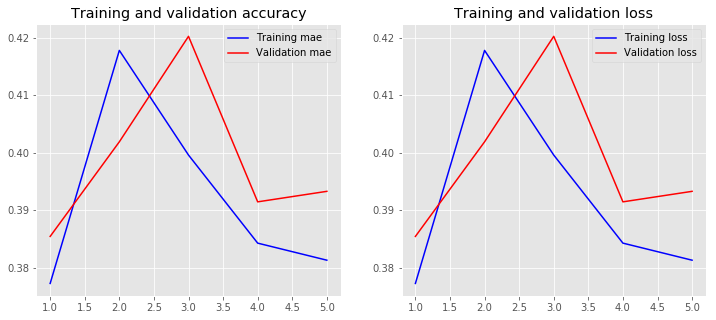

In [166]:
plot_model_fit_result(nn_model_fit_result)

## Predict

In [48]:
y_train[:10]

array([1, 0, 0, 1, 1, 0, 0, 1, 1, 1], dtype=int64)

In [462]:
test_case

"Admission Date:                Discharge Date:   Date of Birth:               Sex:   MService: NEUROSURGERYAllergies:Patient recorded as having No Known Allergies to DrugsAttending:Chief Complaint:struck in the back of the headMajor Surgical or Invasive Procedure::Left temporal craniotomy and evacuation ofepidural hematoma.History of Present Illness:21 year-old man who was witnessed to be struck in the back ofthe head by an unidentified object in earlierthis morning (roughly 1.5 hours ago). Patient then fellbackward, striking the occiput. EMS was called and he was foundsupine on the ground. EMS trip sheet not available and initialexamination unclear.Past Medical History:unknown at presentSocial History:only child / mother and stepfather from  / he is asenior .Family History:unknownPhysical Exam:PHYSICAL EXAM:O: T: F BP: 105/75   HR: 80   R: 14  O2Sats: 100%Gen: Lying in bed with eyes closed.HEENT: Scalp laceration over occiput oozing blood.Neck: In hard collar.Lungs: CTA bilaterally.C

In [461]:
test_case=X_train[1]

In [59]:
lgbm_input=tfidf_transformer.transform([test_case])

In [183]:
lgbm_prob_output=lgbm_model.predict_proba(lgbm_input)[0, 1]

In [184]:
lgbm_prob_output

0.5101406211343565

In [62]:
nn_unpadded_input=[[tfidf2_dict[word] for word in note.split() if word in tfidf2_dict.keys()] for note in [test_case]]

In [63]:
maxlen=2000
nn_padded_input=pad_sequences(nn_unpadded_input, dtype='float32', padding='post', maxlen=maxlen)

In [138]:
nn_output=nn_model.predict(nn_padded_input)[0,0]

In [140]:
nn_output

0.5203931

## Plot

In [84]:
lgbm_importance_list=lgbm_model.feature_importances_.tolist()

In [101]:
lgbm_min_importance=min([i for i in lgbm_importance_list if i!=0])/10
lgbm_importance_list_fixed=[lgbm_min_importance if i==0 else i for i in lgbm_importance_list]

In [85]:
lgbm_feature_name_list=tfidf_transformer.get_feature_names()

In [446]:
max(lgbm_feature_name_list)

'unspecified essential hypertension'

In [102]:
importance_dict=dict((i,j) for (i,j) in zip(lgbm_feature_name_list, lgbm_importance_list_fixed) if j!=0)
importance_dict

{'essential': 591,
 'essential hypertension': 28.7,
 'hypertension': 627,
 'unspecified': 287,
 'unspecified essential': 28.7,
 'unspecified essential hypertension': 28.7}

In [103]:
from wordcloud import WordCloud 

In [104]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate_from_frequencies(importance_dict) 

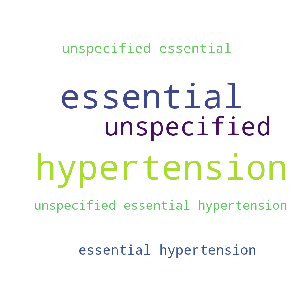

In [105]:
plt.figure(figsize = (4, 4), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

In [187]:
lgbm_contri_output=lgbm_model.predict_proba(lgbm_input,pred_contrib=True).tolist()[0]

In [332]:
lgbm_contri_output

[0.0025241999848575848,
 0.0,
 0.6098181369229614,
 0.0031612580851954866,
 0.0,
 0.0,
 -0.5749355475767552]

In [355]:
prob_cum_list=list(1/(1+np.exp(-np.cumsum(lgbm_contri_output))))
prob_cum_list.insert(0,0)
prob_cum_list

[0,
 0.5006310496611488,
 0.5006310496611488,
 0.6484749354596063,
 0.6491952219792482,
 0.6491952219792482,
 0.6491952219792482,
 0.5101406211343561]

In [356]:
prob_list=list(np.diff(prob_cum_list))
prob_list.append(min(max(prob_cum_list[-1]+nn_output,0),1)-prob_cum_list[-1])
prob_list

[0.5006310496611488,
 0.0,
 0.14784388579845753,
 0.000720286519641844,
 0.0,
 0.0,
 -0.13905460084489207,
 0.4898593788656439]

In [357]:
prob_source_name_list=['Intercept']
prob_source_name_list.extend(lgbm_feature_name_list)
prob_source_name_list.append('convolutional neural network')
prob_source_name_list

['Intercept',
 'essential',
 'essential hypertension',
 'hypertension',
 'unspecified',
 'unspecified essential',
 'unspecified essential hypertension',
 'convolutional neural network']

In [421]:
trans = pd.DataFrame(data={'Importance': prob_list},index=prob_source_name_list).sort_values(by=['Importance'])
trans

,Importance
unspecified essential hypertension,-0.139055
essential,0.000000
unspecified,0.000000
unspecified essential,0.000000
hypertension,0.000720
essential hypertension,0.147844
convolutional neural network,0.489859
Intercept,0.500631


In [422]:
blank=trans.Importance.cumsum().shift(1).fillna(0)
blank

unspecified essential hypertension    0.000000
essential                            -0.139055
unspecified                          -0.139055
unspecified essential                -0.139055
hypertension                         -0.139055
essential hypertension               -0.138334
convolutional neural network          0.009510
Intercept                             0.499369
Name: Importance, dtype: float64

In [423]:
total = trans.sum().Importance
trans.loc["net"] = -total
blank.loc["net"] = total

In [424]:
trans

,Importance
unspecified essential hypertension,-0.139055
essential,0.000000
unspecified,0.000000
unspecified essential,0.000000
hypertension,0.000720
essential hypertension,0.147844
convolutional neural network,0.489859
Intercept,0.500631
net,-1.000000


In [425]:
blank

unspecified essential hypertension    0.000000
essential                            -0.139055
unspecified                          -0.139055
unspecified essential                -0.139055
hypertension                         -0.139055
essential hypertension               -0.138334
convolutional neural network          0.009510
Intercept                             0.499369
net                                   1.000000
Name: Importance, dtype: float64

In [426]:
step = blank.reset_index(drop=True).repeat(3).shift(-1)
step[1::3] = np.nan

In [456]:
my_plot=plt.figure(figsize = (4, 4)) 

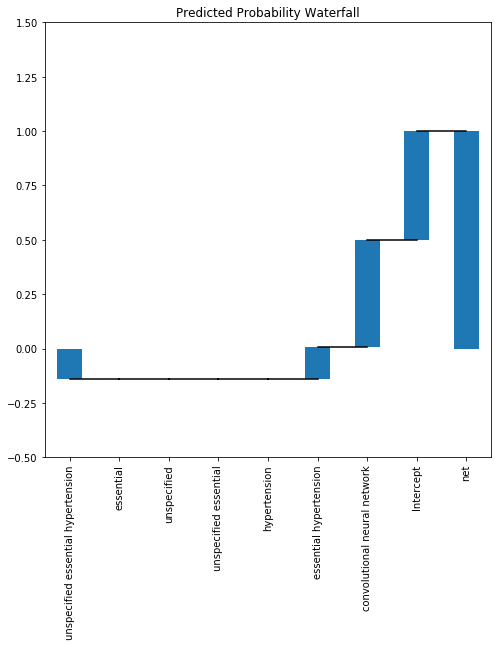

In [460]:
my_plot = trans.plot(kind='bar', stacked=True, bottom=blank,legend=None, title="Predicted Probability Waterfall",ylim=(-0.5,1.5),figsize=(8,8))
my_plot.plot(step.index, step.values,'k')

In [459]:
type(my_plot)

matplotlib.axes._subplots.AxesSubplot